<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/improve-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip', quoting=3, low_memory=False)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %20 oranında rastgele bir alt küme seç
sampled_df = df.sample(frac=0.2, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (4941, 10)
Yeni veri seti boyutu: (988, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


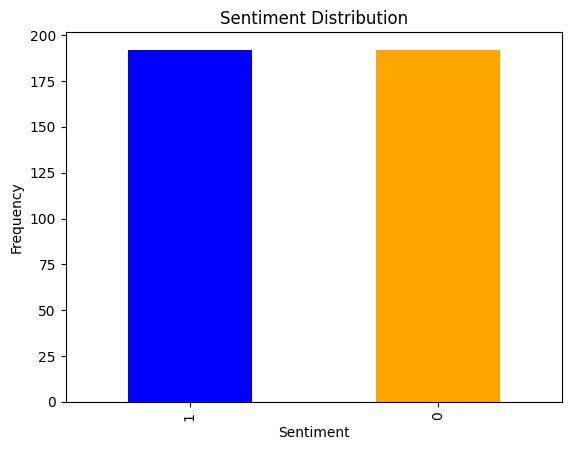

Ortalama Yorum Uzunluğu: 137.765625
Standart Sapma: 85.54831451019504
Aykırı değerler çıkarıldıktan sonra veri seti boyutu: (380, 2)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score']]

    # Skorları ikili hale getirin (örneğin: 1-3 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]

print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

SVM with SMOTE Accuracy: 0.8484848484848485
SVM with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.37      0.48        38
           1       0.87      0.96      0.91       160

    accuracy                           0.85       198
   macro avg       0.78      0.67      0.70       198
weighted avg       0.83      0.85      0.83       198

SVM with SMOTE Confusion Matrix:
 [[ 14  24]
 [  6 154]]


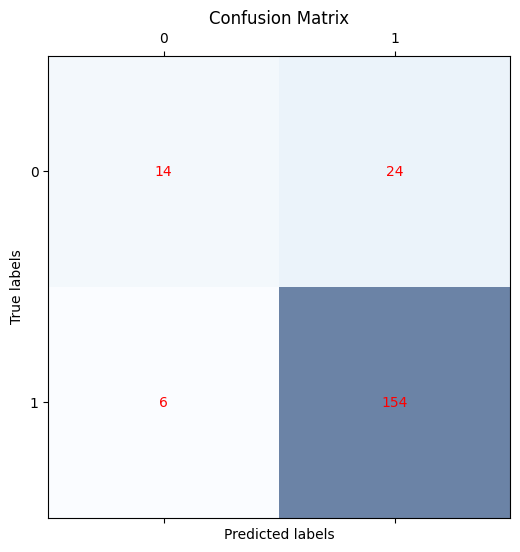

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def svm_with_smote_sentiment_analysis(df):
    """Verilen veri setinde SVM (Support Vector Machine) ve SMOTE ile duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır, sınıf dengesini korumak için stratify kullan
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']  # Stratify ile sınıf dengesini korur
    )

    # TF-IDF vektörleştirme - Bigrams kullanarak özellik sayısını artırıyoruz
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # 1. ve 2. n-gramları kullanıyoruz
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SMOTE ile azınlık sınıfını artırma
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # SVM modelini oluştur ve eğit
    model = SVC(kernel='linear', class_weight='balanced', random_state=42)  # SVM modelini oluşturuyoruz
    model.fit(X_train_resampled, y_train_resampled)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Accuracy, Classification Report ve Confusion Matrix'i döndür
    return accuracy, report, cm

# SVM analizi SMOTE ile
accuracy, report, cm = svm_with_smote_sentiment_analysis(prepared_data)

# Sonuçları yazdır
print("SVM with SMOTE Accuracy:", accuracy)
print("SVM with SMOTE Classification Report:\n", report)
print("SVM with SMOTE Confusion Matrix:\n", cm)

# Confusion Matrix görselleştirme
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

Naive Bayes with SMOTE Accuracy: 0.8080808080808081
Naive Bayes with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.74      0.60        38
           1       0.93      0.82      0.87       160

    accuracy                           0.81       198
   macro avg       0.71      0.78      0.73       198
weighted avg       0.85      0.81      0.82       198

Naive Bayes with SMOTE Confusion Matrix:
 [[ 28  10]
 [ 28 132]]


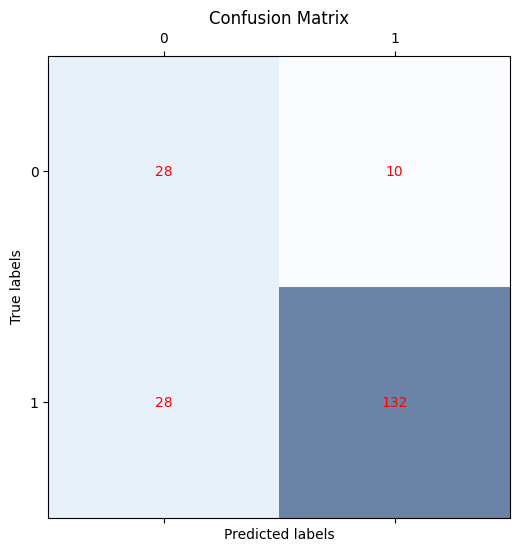

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def naive_bayes_sentiment_analysis_with_smote(df):
    """Verilen veri setinde Naive Bayes (MultinomialNB) ve SMOTE ile duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır, sınıf dengesini korumak için stratify kullan
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']  # Stratify ile sınıf dengesini korur
    )

    # TF-IDF vektörleştirme - Bigrams kullanarak özellik sayısını artırıyoruz
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # 1. ve 2. n-gramları kullanıyoruz
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SMOTE ile azınlık sınıfını artırma
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # Naive Bayes modelini oluştur ve eğit
    model = MultinomialNB(alpha=1.0)  # Alpha parametresi smoothing için kullanılır
    model.fit(X_train_resampled, y_train_resampled)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Accuracy, Classification Report ve Confusion Matrix'i döndür
    return accuracy, report, cm

# Naive Bayes analizi SMOTE ile
accuracy, report, cm = naive_bayes_sentiment_analysis_with_smote(prepared_data)

# Sonuçları yazdır
print("Naive Bayes with SMOTE Accuracy:", accuracy)
print("Naive Bayes with SMOTE Classification Report:\n", report)
print("Naive Bayes with SMOTE Confusion Matrix:\n", cm)

# Confusion Matrix görselleştirme
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.5149 - loss: 1.0095 - val_accuracy: 0.1919 - val_loss: 1.0109
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.5343 - loss: 0.9414 - val_accuracy: 0.1919 - val_loss: 0.8927
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.5071 - loss: 0.9470 - val_accuracy: 0.2727 - val_loss: 0.9117
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5068 - loss: 0.9419 - val_accuracy: 0.4949 - val_loss: 0.7243
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.5368 - loss: 0.9338 - val_accuracy: 0.4596 - val_loss: 0.7696
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.5611 - loss: 0.9027 - val_accuracy: 0.5657 - val_loss: 0.7676
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.5981 - loss: 0.8833 - val_accuracy: 0.4798 - val_loss: 0.8551
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.5400 - loss: 0.9035 - val_accuracy

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
Redesigned RNN with ADASYN Accuracy: 0.5252525252525253
Redesigned RNN with ADASYN Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.61      0.33        38
           1       0.84      0.51      0.63       160

    accuracy                           0.53       198
   macro avg       0.53      0.56      0.48       198
weighted avg       0.73      0.53      0.57       198

Redesigned RNN with ADASYN Confusion Matrix:
 [[23 15]
 [79 81]]


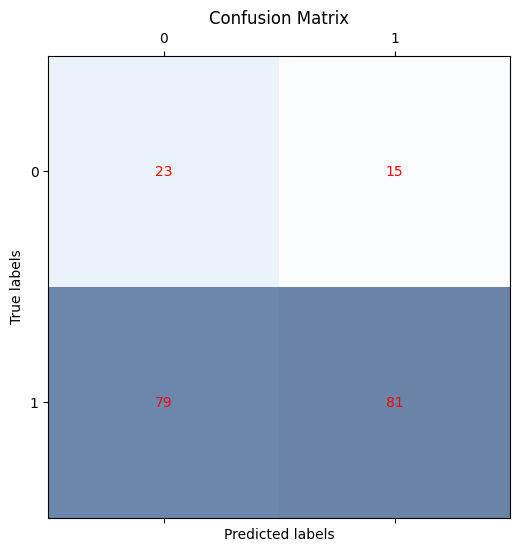

In [14]:
from imblearn.over_sampling import ADASYN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

def redesigned_rnn_with_balancing(df):
    """Daha iyi performans için yeniden tasarlanmış RNN (Bidirectional LSTM) ve dengeleme ile duygu analizi."""

    # Eğitim ve test seti ayırma
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']
    )

    # Word2Vec modelini eğit ve kelime vektörlerini oluştur
    w2v_model = Word2Vec(sentences=X_train.str.split(), vector_size=100, window=5, min_count=1, workers=4)
    vocab_size = len(w2v_model.wv)

    # Word2Vec ile kelimeleri vektörlere dönüştür
    def get_word_embeddings(texts, max_length=100):
        embeddings = np.zeros((len(texts), max_length, 100))
        for i, sentence in enumerate(texts.str.split()):
            for j, word in enumerate(sentence[:max_length]):
                if word in w2v_model.wv:
                    embeddings[i, j] = w2v_model.wv[word]
                else:
                    embeddings[i, j] = np.random.normal(size=(100,))  # Bilinmeyen kelimeler için rastgele vektör
        return embeddings

    X_train_embed = get_word_embeddings(X_train)
    X_test_embed = get_word_embeddings(X_test)

    # ADASYN ile veri dengesini sağlama
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_embed.reshape(len(X_train), -1), y_train)
    X_train_resampled = X_train_resampled.reshape(-1, 100, 100)

    # Model yapısı
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 100)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Sınıf ağırlıkları ile derleme
    class_weights = {0: 2, 1: 1}  # Sınıflar arasında denge sağlamak için ağırlıklar
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Modeli eğit
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test_embed, y_test), class_weight=class_weights)

    # Test verisi üzerinde tahmin yap
    y_pred = (model.predict(X_test_embed) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Sonuçları döndürme
    return accuracy, report, cm

# Yeni modeli çalıştırma
accuracy, report, cm = redesigned_rnn_with_balancing(prepared_data)

# Sonuçları yazdır
print("Redesigned RNN with ADASYN Accuracy:", accuracy)
print("Redesigned RNN with ADASYN Classification Report:\n", report)
print("Redesigned RNN with ADASYN Confusion Matrix:\n", cm)

# Confusion Matrix görselleştirme
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

Lexicon-Based SMOTE Accuracy: 0.6451005025125628
Lexicon-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.82      0.70       796
           1       0.72      0.47      0.57       796

    accuracy                           0.65      1592
   macro avg       0.67      0.65      0.63      1592
weighted avg       0.67      0.65      0.63      1592

Lexicon-Based SMOTE Confusion Matrix:
 [[652 144]
 [421 375]]


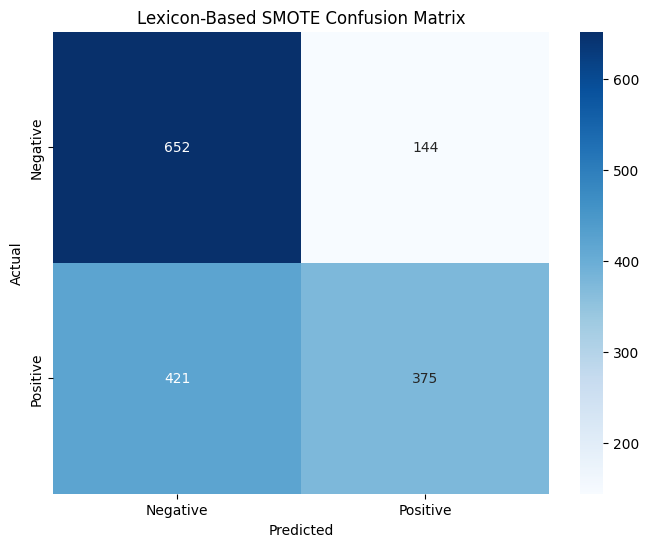

In [10]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Pozitif ve negatif kelimelerin listesi
positive_words = ['good', 'great', 'excellent', 'awesome', 'nice']
negative_words = ['bad', 'terrible', 'poor', 'worst', 'awful']

def lexicon_based_sentiment_analysis_with_smote(df):
    """Lexicon-based sentiment analizi SMOTE ile."""

    # Her yorumdaki kelimeleri analiz ederek duygu puanı döndür
    def get_sentiment(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1
        return 1 if score > 0 else 0

    # Duygu etiketlerini tahmin et
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # SMOTE uygulama
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(df['Lexicon_Sentiment'].values.reshape(-1, 1), df['Sentiment'])

    # Tahminleri değerlendirme
    accuracy = accuracy_score(y_res, X_res)
    report = classification_report(y_res, X_res)
    cm = confusion_matrix(y_res, X_res)

    # Sonuçları yazdır
    print("Lexicon-Based SMOTE Accuracy:", accuracy)
    print("Lexicon-Based SMOTE Classification Report:\n", report)
    print("Lexicon-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix'i görselleştir
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Lexicon-Based SMOTE Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, report, cm

# Lexicon-based fonksiyonunu çağırma
accuracy, report, cm = lexicon_based_sentiment_analysis_with_smote(prepared_data)

Aspect-Based SMOTE Accuracy (Hız): 0.5113065326633166
Aspect-Based SMOTE Classification Report (Hız):
               precision    recall  f1-score   support

           0       0.51      0.98      0.67       796
           1       0.67      0.04      0.08       796

    accuracy                           0.51      1592
   macro avg       0.59      0.51      0.37      1592
weighted avg       0.59      0.51      0.37      1592

Aspect-Based SMOTE Confusion Matrix (Hız):
 [[779  17]
 [761  35]]
Aspect-Based SMOTE Accuracy (Kalite): 0.6086683417085427
Aspect-Based SMOTE Classification Report (Kalite):
               precision    recall  f1-score   support

           0       0.59      0.74      0.65       796
           1       0.65      0.48      0.55       796

    accuracy                           0.61      1592
   macro avg       0.62      0.61      0.60      1592
weighted avg       0.62      0.61      0.60      1592

Aspect-Based SMOTE Confusion Matrix (Kalite):
 [[587 209]
 [414 382

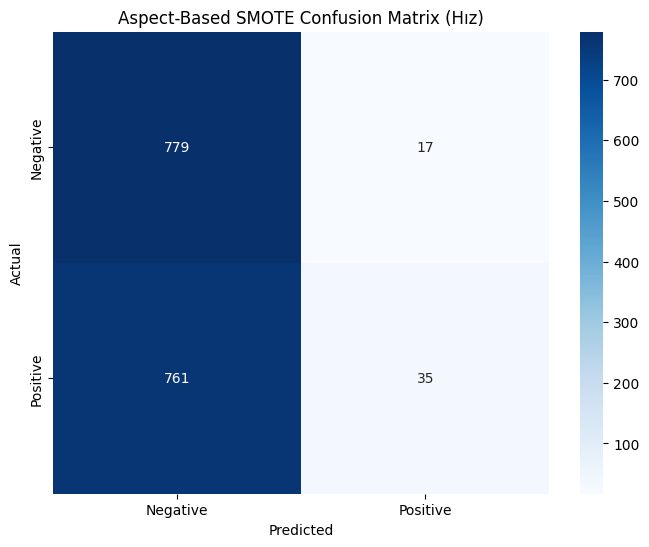

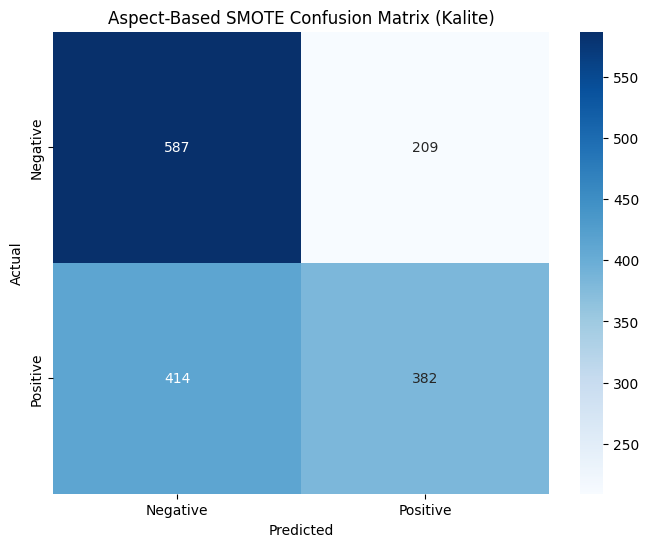

In [11]:
# Aspect kelime listeleri
aspects = {
    'hız': ['fast', 'quick', 'speed', 'late', 'delayed'],
    'kalite': ['good', 'great', 'excellent', 'poor', 'bad', 'terrible', 'quality']
}

def aspect_based_sentiment_analysis_with_smote(df):
    """Aspect-based sentiment analizi SMOTE ile."""

    # Her özellik için duygu analizi yap
    def get_aspect_sentiment(text):
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}
        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    aspect_scores[aspect] += 1
        return int(aspect_scores['hız'] > 0), int(aspect_scores['kalite'] > 0)

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # SMOTE uygulama
    smote = SMOTE(random_state=42)
    X_res_hız, y_res_hız = smote.fit_resample(df['Aspect_Hız'].values.reshape(-1, 1), df['Sentiment'])
    X_res_kalite, y_res_kalite = smote.fit_resample(df['Aspect_Kalite'].values.reshape(-1, 1), df['Sentiment'])

    # Hız için doğruluk ve rapor
    accuracy_hız = accuracy_score(y_res_hız, X_res_hız)
    report_hız = classification_report(y_res_hız, X_res_hız)
    cm_hız = confusion_matrix(y_res_hız, X_res_hız)

    # Kalite için doğruluk ve rapor
    accuracy_kalite = accuracy_score(y_res_kalite, X_res_kalite)
    report_kalite = classification_report(y_res_kalite, X_res_kalite)
    cm_kalite = confusion_matrix(y_res_kalite, X_res_kalite)

    # Sonuçları yazdır
    print("Aspect-Based SMOTE Accuracy (Hız):", accuracy_hız)
    print("Aspect-Based SMOTE Classification Report (Hız):\n", report_hız)
    print("Aspect-Based SMOTE Confusion Matrix (Hız):\n", cm_hız)
    print("Aspect-Based SMOTE Accuracy (Kalite):", accuracy_kalite)
    print("Aspect-Based SMOTE Classification Report (Kalite):\n", report_kalite)
    print("Aspect-Based SMOTE Confusion Matrix (Kalite):\n", cm_kalite)

    # Confusion matrix görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_hız, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Aspect-Based SMOTE Confusion Matrix (Hız)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_kalite, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Aspect-Based SMOTE Confusion Matrix (Kalite)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy_hız, report_hız, cm_hız, accuracy_kalite, report_kalite, cm_kalite

# Aspect-based fonksiyonunu çağırma
accuracy_hız, report_hız, cm_hız, accuracy_kalite, report_kalite, cm_kalite = aspect_based_sentiment_analysis_with_smote(prepared_data)